In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

In [3]:
from tf_rl.simulation.manipulation import GameObject, HeroSimulation, objects_colliding

In [4]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp2epiacd_


In [25]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from collections import defaultdict
from euclid import Circle, Point2, Vector2, LineSegment2
from itertools import combinations

import tf_rl.utils.svg as svg

class Manipulation(HeroSimulation):
    def __init__(self, settings):
        super(Manipulation, self).__init__(settings)
        self.actions = [Vector2(*a) for a in self.settings["action_acc"]]
        self.num_actions = len(self.actions)
        
#         self.target     = GameObject(Point2(0, 0), Vector2(0,0), "red", mass=2.0, radius=self.settings['obj_radius'])
#         self.randomize_position(self.target, margin=2 * self.settings['obj_radius']) 
#         self.add(self.target)

#         self.tool     = GameObject(Point2(0, 0), Vector2(0,0), "blue", mass=2.0, radius=self.settings['obj_radius'])
#         self.randomize_position(self.tool, margin=2 * self.settings['obj_radius'])
#         self.add(self.tool)
        
        self.randomize_position(self.hero)
        
        self.prev_distance = self.distance_to_minimize()
        
    def distance_to_minimize(self):
#         return self.tool.position.distance(self.target.position)
        return self.hero.position.distance(Point2(0.5, 0.5))

    def randomize_position(self, obj, noncoliding=True, margin=0.0):
        gen = lambda: random.uniform(obj.radius + margin, 1.0 - obj.radius - margin)
        obj.position = Point2(gen(), gen())
                
        while noncoliding and any(objects_colliding(obj, other) for other in self.objects if other is not obj):
            obj.position = Point2(gen(), gen())
                                         
    def perform_action(self, action):
        self.hero.speed += self.actions[action]

    def collect_reward(self):
        new_distance = self.distance_to_minimize()
        delta = self.prev_distance - new_distance 
        self.prev_distance = new_distance
        return 100.0*delta
    
    def success(self):
        return self.distance_to_minimize() < 0.1
#         return self.tool.position.distance(self.target.position) < (self.target.radius + self.tool.radius) * 1.5
    
    def to_html(self, stats=[]):
        stats = stats[:]
        stats.extend([
            "reward = %.3f" % (self.collect_reward()),
        ])
        return super(Manipulation, self).to_html(stats=stats)

In [26]:
SETTINGS = {
    'size': 500,
    'colors': {
        'hero': 'yellow',
        'red':  'red',
        'blue': 'blue'
    },
    'restitution': 0.6,
    'observable_distance': 1.5,
    'num_observation_lines': 32,
    'observable_objects': [
        'red',
        'blue',
        'wall',
    ],
    'action_acc': [
        [0.0,   0.0],    # stay still
        [-0.05, 0.0],    # left
        [0.05,  0.0],    # right
        [0.0,   -0.05],  # up
        [0.0,   0.05],   # down
    ],
    'obj_radius': 0.045,
    'viscosity': 0.97,
}

g = Manipulation(SETTINGS)

In [42]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Tensorflow business - it is always good to reset a graph before creating a new controller.
    tf.ops.reset_default_graph()
    session = tf.InteractiveSession()

    # This little guy will let us run tensorboard
    #      tensorboard --logdir [LOG_DIR]
    journalist = tf.train.SummaryWriter(LOG_DIR)

    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    brain = MLP([g.observation_size,], [100, 50, 50, g.num_actions], 
                [tf.tanh,tf.tanh,tf.tanh, tf.identity])
    
    # The optimizer to use. Here we use RMSProp as recommended
    # by the publication
    optimizer = tf.train.AdamOptimizer(learning_rate= 0.001, beta1=0.5)

    #     optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

    # DiscreteDeepQ object
    current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                       discount_rate=0.99, exploration_period=5000, max_experience=10000, 
                                       store_every_nth=2, train_every_nth=2,
                                       target_network_update_rate=0.001,
                                       summary_writer=journalist)
    
    session.run(tf.initialize_all_variables())
    session.run(current_controller.target_network_update)
    # graph was not available when journalist was created  
    journalist.add_graph(session.graph_def)

Exception ignored in: <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f0b32512860>>
Traceback (most recent call last):
  File "/usr/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 122, in __del__
    self.close()
  File "/usr/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 622, in close
    self._default_session.__exit__(None, None, None)
  File "/usr/lib64/python3.4/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2791, in get_controller
    assert self.stack[-1] is default
AssertionError: 


In [43]:
results = []

In [ ]:
FPS          = 30
ACTION_EVERY = 3
SIM_TIME     = 15
    
fast_mode = True
training  = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 100
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    while True:
        g = Manipulation(SETTINGS)
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 training=training,
                 max_frames=SIM_TIME * FPS,
                 save_path=None)
        results.append(1 if g.success() else 0)
except KeyboardInterrupt:
    print("Interrupted")

[ 1.05438664  0.68027729]


(0.0, 1.0)

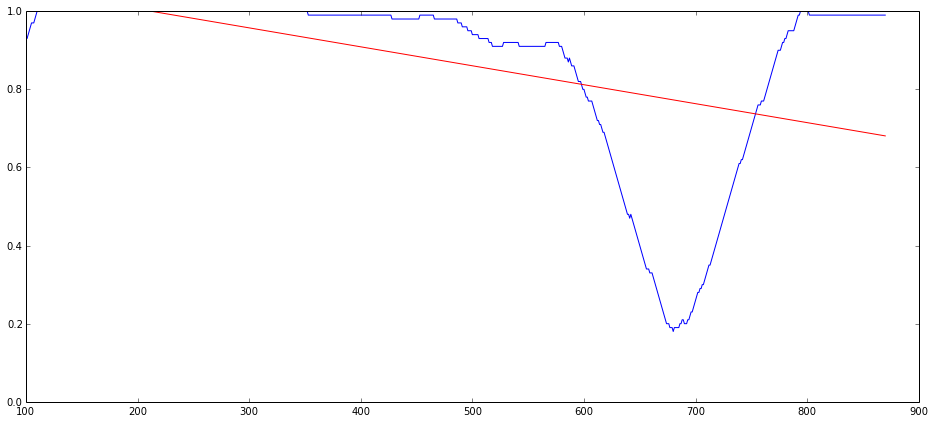

In [41]:
SMOOTHING=100
x = range(SMOOTHING, len(results))
y = [sum(results[i-SMOOTHING:i]) / SMOOTHING for i in x]
f = plt.figure(figsize=(16,7))
plt.plot(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(p([SMOOTHING, len(results)]))
plt.plot(x,p(x),color="red")
plt.gca().set_ylim([0.0, 1.0])

In [217]:
import time
from IPython.display import display, clear_output

try:
    while True:
        g.step(0.03)
        time.sleep(0.03)
        clear_output(wait=True)
        display(g.to_html())
except KeyboardInterrupt:
    print('Interrupted')

Interrupted


8

In [383]:
np.get_printoptions()

{'edgeitems': 3,
 'formatter': None,
 'infstr': 'inf',
 'linewidth': 75,
 'nanstr': 'nan',
 'precision': 8,
 'suppress': False,
 'threshold': 1000}

In [386]:
np.set_printoptions(formatter={'float_kind':lambda x: '%.2f\t' % (x,)})
# g.__class__ = HeroSimulation
print(g.observe().reshape(SETTINGS["num_observation_lines"], len(SETTINGS["observable_objects"]) + 4))
np.set_printoptions(formatter=None)
g.to_html()


[[1.00	 1.00	 0.23	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.23	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.20	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.14	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.11	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.09	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.09	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.11	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.14	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.20	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.39	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.44	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.45	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.48	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 0.19	 1.00	 -0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.63	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.71	 0.00	 0.00	 -

In [361]:
SETTINGS["num_observation_lines"], len(SETTINGS["observable_objects"]) + 4

(32, 6)

In [362]:
m.observe().shape

(16, 6)